In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from lmfit import Model

c6 = ['#B19CD8','#40ada6','#3c4ebf',  
        '#e3a600', '#edb1a3', '#d6543a',]

dpi = 300

/home/gokul/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
from torchvision import datasets, transforms, models
import torch
from collections import Counter
from latentmi import ksg


transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB") if img.mode != "RGB" else img),  # ensure RGB
    transforms.Resize((240, 240)),  # resize to a manageable resolution
    transforms.ToTensor(),  # convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # normalize
])

# load dataset
Caltech101 = datasets.Caltech101(root='../data', download=True, transform=transform)

# get class labels
labels = Caltech101.y  # class indices for the dataset

# count occurrences of each class
class_counts = Counter(labels)

# find top n largest classes
top_n = 5
top_n_classes = [cls for cls, _ in class_counts.most_common(top_n)]

# subset the dataset to include only samples from these top classes
indices = [i for i, label in enumerate(labels) if label in top_n_classes]
subset = torch.utils.data.Subset(Caltech101, indices)

# split the subset into train and validation sets
N = len(subset)
print(f"{N} total samples")
train_set, val_set = torch.utils.data.random_split(subset, [N//2, N - N//2])

# create data loaders
data_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False)

subset_labels = [subset.dataset[i][1] for i in range(len(subset))]
entropy_5_class = ksg.entropyd(subset_labels)

Files already downloaded and verified
2707 total samples


In [3]:
df_gaussian = pd.read_csv('Caltech101_Gaussian.csv', index_col=0)
df_resolution = pd.read_csv('Caltech101_Resolution.csv', index_col=0)

All
X bar:  0.13581370254718445
I max:  2.3806378391714564

Watches
X bar:  0.22604050315751525
I max:  1.208833520864687

Airplanes
X bar:  0.05740454078799503
I max:  1.0677707171527822

Motorbikes
X bar:  0.05675594952005437
I max:  1.0611818452159898

Faces2
X bar:  0.041052308713640163
I max:  1.0009488994756475

Faces1
X bar:  0.08631624125270837
I max:  1.070740299378371

All
X bar:  0.11916491577246478
I max:  2.149108309871837

Watches
X bar:  0.41222390778375007
I max:  0.9899733756269362

Airplanes
X bar:  0.0753378102134183
I max:  0.9989710867197019

Motorbikes
X bar:  0.03174406159723839
I max:  0.9756074905132698

Faces2
X bar:  0.039397468134992925
I max:  0.942826832668347

Faces1
X bar:  0.15187916954671216
I max:  1.0172352218870115



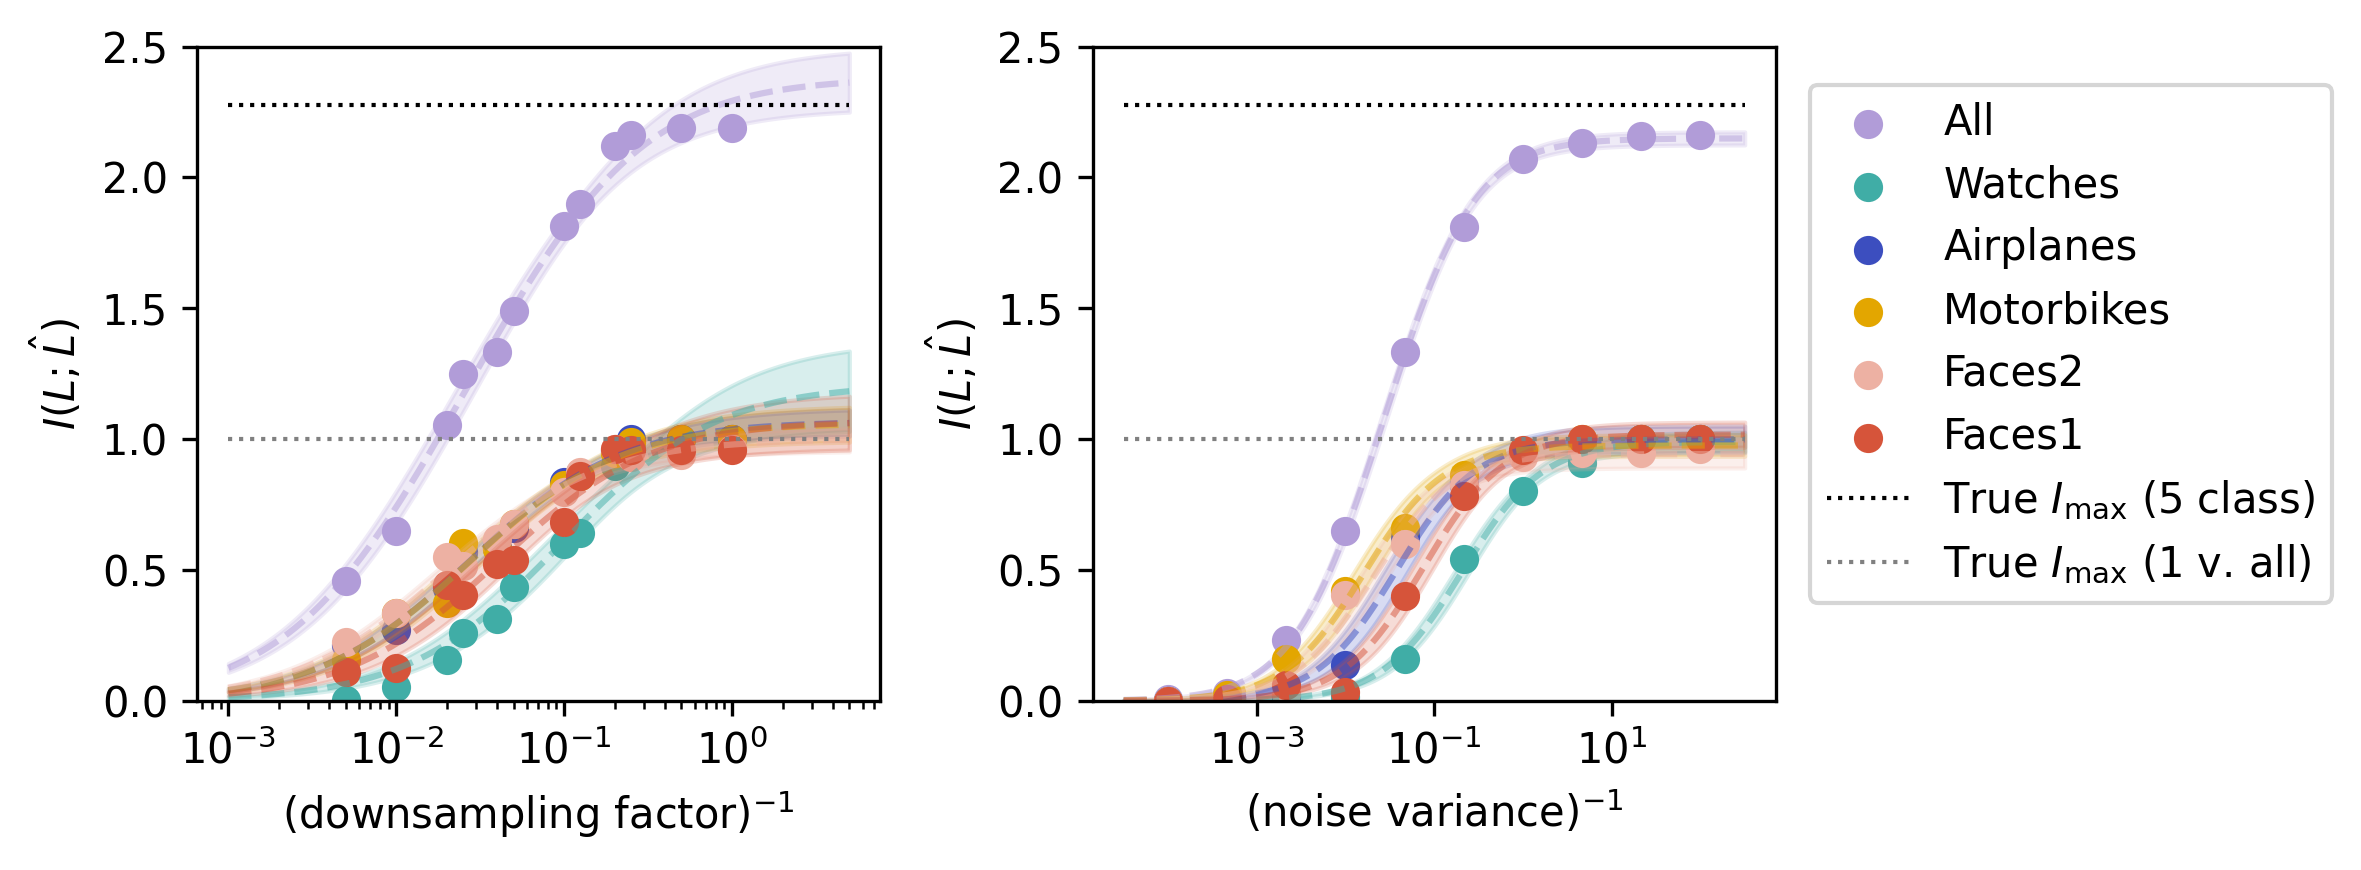

In [9]:
def info_scaling(x, A, B):
    return 0.5 * np.log2((x*B+ 1)/(1+A*x))

fig, axs = plt.subplots(1,2, figsize=(8,3), dpi=dpi)

df = df_resolution

classes = sorted(df[df['N instances of label'] > 100]['Class label'].unique())
class_names = ['Faces1', 'Faces2', 'Motorbikes', 'Airplanes', 'Watches', 'All']
palette = c6


for i, x in enumerate(classes[::-1]):
    # prepare data
    x_data = (1 / (df[df['Class label'] == x]['Factor']))
    y_data = df[df['Class label'] == x]['MI']

    # create model and parameters
    model = Model(info_scaling)
    params = model.make_params(A=1e-2, B=1e-2)  # initial guesses
    params['A'].min = 0  # set bounds
    params['B'].min = 0

    # fit model
    result = model.fit(y_data, params, x=x_data)

    # generate fit line
    x_fit = np.linspace(x_data.min()/5, 5*x_data.max(), 10**5)
    y_fit = model.eval(params=result.params, x=x_fit)

    # calculate confidence bands
    y_upper = result.eval_uncertainty(params=result.params, 
                                      x=x_fit, sigma=2)
    y_lower = -y_upper

    # plot fit and data
    axs[0].plot(x_fit, y_fit, linestyle='--', color=palette[i], alpha=0.5)
    axs[0].fill_between(x_fit, y_fit + y_upper, y_fit + y_lower, color=palette[i], alpha=0.2)
    axs[0].scatter(x_data, y_data, color=palette[i], label=class_names[::-1][i])

    print(class_names[::-1][i])
    print("X bar: ", 1/result.params['A'].value)
    print("I max: ", 0.5*np.log2(result.params['B'].value/result.params['A'].value))
    print()



axs[0].plot([np.min(x_fit), np.max(x_fit)], [entropy_5_class, entropy_5_class], linestyle='dotted',
         color='k', label=r'$\log(5)$', lw=1)
axs[0].plot([np.min(x_fit), np.max(x_fit)], [1, 1], linestyle='dotted', 
         color='grey', label=r'$\log(2)$', lw=1)

axs[0].set_xlabel(r'$\text{(downsampling factor)}^{-1}$')
axs[0].set_ylabel(r'$I(L; \hat{L})$')
axs[0].set_xscale('log')

df = df_gaussian

classes = sorted(df[df['N instances of label'] > 100]['Class label'].unique())
class_names = ['Faces1', 'Faces2', 'Motorbikes', 'Airplanes', 'Watches', 'All']
palette = c6


for i, x in enumerate(classes[::-1]):
    # prepare data
    x_data = (1 / (df[df['Class label'] == x]['Scale'])**2)
    y_data = df[df['Class label'] == x]['MI']

    # create model and parameters
    model = Model(info_scaling)
    params = model.make_params(A=1e-2, B=1e-2)  # initial guesses
    params['A'].min = 0  # set bounds
    params['B'].min = 0

    # fit model
    result = model.fit(y_data, params, x=x_data)

    # generate fit line
    x_fit = np.logspace(-4.5, 2.5, 10**5)
    y_fit = model.eval(params=result.params, x=x_fit)

    # calculate confidence bands
    y_upper = result.eval_uncertainty(params=result.params, 
                                      x=x_fit, sigma=2)
    y_lower = -y_upper

    # plot fit and data
    axs[1].plot(x_fit, y_fit, linestyle='--', color=palette[i], alpha=0.5)
    axs[1].fill_between(x_fit, y_fit + y_upper, y_fit + y_lower, color=palette[i], alpha=0.2)
    axs[1].scatter(x_data, y_data, color=palette[i], label=class_names[::-1][i])


    print(class_names[::-1][i])
    print("X bar: ", 1/result.params['A'].value)
    print("I max: ", 0.5*np.log2(result.params['B'].value/result.params['A'].value))
    print()


axs[1].plot([np.min(x_fit), np.max(x_fit)], [entropy_5_class, entropy_5_class], linestyle='dotted',
         color='k', label=r'True $I_{\max}$ (5 class)', lw=1)
axs[1].plot([np.min(x_fit), np.max(x_fit)], [1, 1], linestyle='dotted', 
         color='grey', label=r'True $I_{\max}$ (1 v. all)', lw=1)

axs[1].set_xlabel(r'$\text{(noise variance)}^{-1}$')
axs[1].set_ylabel(r'$I(L; \hat{L})$')
axs[1].set_xscale('log')
axs[1].legend(loc=(1.05, 0.15))

axs[1].set_ylim(0, 2.5)
axs[0].set_ylim(0, 2.5)

plt.tight_layout()
